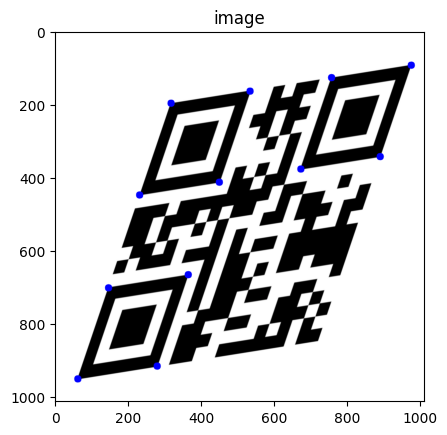

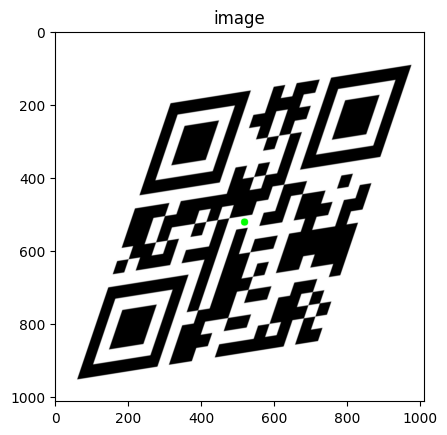

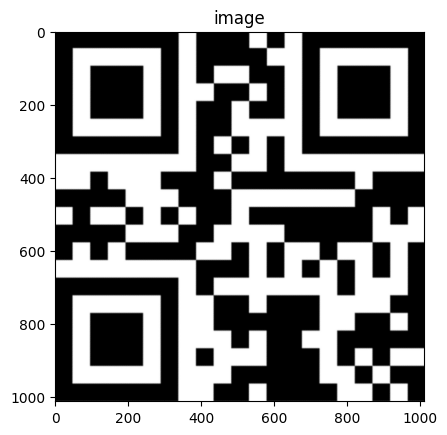

In [33]:
import cv2 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import utils as ut

def biggestContours(contours,numberOfContours=1):
    # Sort the contours by area in descending order
    contours = [np.array(contour) for contour in contours]
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:numberOfContours]
    return contours

def computeCenter(contours):
    # Combine contours into one array
    if len(contours)==0:
        return None
    
    combined_contour = np.vstack(contours)

    # Compute bounding box for the combined contours
    x, y, w, h = cv2.boundingRect(combined_contour)

    # Calculate center point of the bounding box
    center_x = x + w // 2
    center_y = y + h // 2

    return (center_x, center_y)

def find_missing_point(point1, point2, known_point):
    point1 = list(point1.ravel())
    point2 = list(point2.ravel())
    known_point = list(known_point.ravel())
    # Determine the direction vector of the first line
    direction_vector1 = np.array(point2) - np.array(point1)
    
    # Find the equation of the first line (y = mx + c)
    m1 = direction_vector1[1] / direction_vector1[0]  # Slope
    c1 = point1[1] - m1 * point1[0]  # Intercept
    
    
    # Find the equation of the second line
    m2 = m1  # Lines are parallel, so slopes are equal
    c2 = known_point[1] - m2 * known_point[0]  # Intercept

    # Calculate the length of the vector
    vector_length = np.linalg.norm(direction_vector1)
    
    # Find the x-coordinate of the intersection point
    intersection_x = known_point[0] + vector_length*np.cos(np.arctan(m1))
    
    # Find the y-coordinate of the intersection point
    intersection_y = known_point[1] + vector_length*np.sin(np.arctan(m1))
    
    return intersection_x, intersection_y

imagePaths= ut.getImagePathsInDirectory("../TC")
# _, axarr = plt.subplots(nrows=1, ncols=2, figsize=(10,5)) # figsize is in inches, yuck

for i,imagePath in enumerate(imagePaths,start=1):
    if imagePath == '../TC\\12.png':
        continue

    imagePath='../TC\\06.png'
    image = cv2.imread(imagePath)
    # image = cv2.GaussianBlur(image, (5, 5), 0)
    # edges = cv2.Canny(image, 50, 150)
    # ut.showImage(edges)

    contours= ut.locatorContours2(image=image,invertColors=False,showImages=False)
    
    locatorBoxes=biggestContours(contours,numberOfContours=3)

    centerPoint=computeCenter(locatorBoxes)
    cv2.circle(center:=image.copy(), centerPoint, 10, (0, 255, 0), -1)
    ut.showImage(ut.drawContourPoints(image.copy(),locatorBoxes))

    ut.showImage(center)

    for i,locatorbox in enumerate(locatorBoxes):  # order all points in the box
        locatorBoxes[i]=ut.orderPoints(locatorbox)
    
    topLeft= topRight= bottomRight= bottomLeft = 0
    for locator in locatorBoxes:
        x, y, w, h = cv2.boundingRect(locator)

        # Calculate center point of the bounding box
        center_x,center_y = x + w // 2,y + h // 2
        
        if center_x> centerPoint[0] and center_y< centerPoint[1]:
            topRight=locator[1]
        
        # elif center_x> centerPoint[0] and center_y> centerPoint[1]:
            # bottomRight=locator[3]
        
        elif center_x< centerPoint[0] and center_y< centerPoint[1]:
            topLeft=locator[0]
        
        elif center_x< centerPoint[0] and center_y> centerPoint[1]:
            bottomLeft=locator[2]
    
    cv2.circle(center, topRight.ravel(), 10, (0, 0, 255), -1)
    cv2.circle(center, bottomLeft.ravel(), 10, (0, 0, 255), -1)
    cv2.circle(center, topLeft.ravel(), 10, (0, 0, 255), -1)
    # cv2.circle(center, bottomRight.ravel(), 10, (0, 0, 255), -1)
    bottomRight=find_missing_point(topLeft,topRight,bottomLeft)
    bottomRight=(int(round(bottomRight[0])),int(round(bottomRight[1])))
    bottomRight=np.array([bottomRight])
    cv2.circle(center, bottomRight.ravel(), 10, (0, 0, 255), -1)
    
    width,height = 1012,1012


    pts1 = np.float32([topLeft.ravel(),topRight.ravel(),bottomLeft.ravel(),bottomRight.ravel()])
    pts2 = np.float32([[0,0],[0,width],[height,0],[width,height]])



    matrix = cv2.getPerspectiveTransform(pts1,pts2)
    output = cv2.warpPerspective(image,matrix,(width,height))

    cv2.imwrite('emad.png',output)

    ut.showImage(output)
    break
    # newContours=[]
    # for j,contour in enumerate(contours):
        # if len(contour)==0:
            # continue
        # 
        # hull = cv2.convexHull(contour)
        # rect=cv2.minAreaRect(contour)
        # box=cv2.boxPoints(rect)
        # box=np.int0(box)
        # 
        # print(f"contour.shape={contour.shape}, contour={contour}")
        # print(f"box.shape={box.shape}, box={box}")
        # plt.sca(axarr[0]); plt.title('contour'); plt.imshow(ut.drawContourPoints(image.copy(),contour));
        # plt.sca(axarr[1]); plt.title('box'); plt.imshow(cv2.drawContours(image.copy(),[box],-1,(0,0,255),4));
        # plt.show()
    #     # Approximate the convex hull polygon (optional)
    #     epsilon = 0.02 * cv2.arcLength(hull, True)
    #     approx = cv2.approxPolyDP(hull, epsilon, True)

    # # if len(approx) == 4:        
    #     # Select the extreme points of the convex hull
    #     leftmost = tuple(approx[approx[:, :, 0].argmin()][0])
    #     rightmost = tuple(approx[approx[:, :, 0].argmax()][0])
    #     topmost = tuple(approx[approx[:, :, 1].argmin()][0])
    #     bottommost = tuple(approx[approx[:, :, 1].argmax()][0])

    #     points=np.array([leftmost,rightmost,topmost,bottommost])
    #     points= ut.orderPoints(points)
    #     newContours.append(points)
    

    # ut.showImage(ut.drawContourPoints(image.copy(),newContours))
    
    # for contour in contours:
    #     if len(contour)==0:
    #         continue
    #     print(f"contours.len={len(contour)}")
    #     # ut.showImage(ut.drawContourPixels(image.copy(),contour))
    #     ut.showImage(ut.drawContourPoints(image.copy(),contour,isPoints=True))
    

    
    
    # for contour in contours:
    #     if len(contour)!=25 or len(contour)!=27:
    #         continue
    #     print(f"contours.shape={contour.shape}, contours.len={len(contour)}")
        
    #     for point in contour:
    #         plt.sca(axarr[0]); plt.title('Contour'); plt.imshow(ut.drawContourPoints(image.copy(),contour));
    #         plt.sca(axarr[1]); plt.title('corner Point'); plt.imshow(ut.drawContourPoints(image.copy(),[[point]]));
    #         plt.show()
    #         ut.printPixelWindow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY),point[0])
            
    #     print(f"contours.shape={contour.shape}, contours.len={len(contour)}")
    #     ut.showImage(ut.drawContourPoints(image.copy(),contour))






    # contours=ut.locatorContours2(image=image,showImages=True)
    
    # ut.drawContourPoints(image,contours)  
    # ut.showImage(image)
    
    # Convert the image to grayscale
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # # Thresholding to extract foreground objects
    # _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # contours=ut.locatorContours(thresh)
    # imageContourPoints=image.copy()
    # ut.drawContourPoints(imageContourPoints,contours)  # Draw the contour points on the image

    



In [ ]:
import cv2
import numpy as np

# Read the original image
original_image = cv2.imread('../TC/06.png')

# Read the reference image or template
reference_image = cv2.imread('../TC/01.png')

# Convert images to grayscale
original_gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
reference_gray = cv2.cvtColor(reference_image, cv2.COLOR_BGR2GRAY)

# Detect ORB keypoints and descriptors
orb = cv2.ORB_create()
keypoints1, descriptors1 = orb.detectAndCompute(original_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(reference_gray, None)

# Match keypoints
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = matcher.match(descriptors1, descriptors2)

# Extract matched keypoints
matched_keypoints1 = np.array([keypoints1[match.queryIdx].pt for match in matches])
matched_keypoints2 = np.array([keypoints2[match.trainIdx].pt for match in matches])

# Estimate homography
H, _ = cv2.findHomography(matched_keypoints1, matched_keypoints2, cv2.RANSAC)

# Warp original image
warped_image = cv2.warpPerspective(original_image, H, (reference_image.shape[1], reference_image.shape[0]))

# Convert warped image to grayscale
warped_gray = cv2.cvtColor(warped_image, cv2.COLOR_BGR2GRAY)

# Perform corner detection on warped image
corners = cv2.goodFeaturesToTrack(warped_gray, maxCorners=100, qualityLevel=0.01, minDistance=10)

# Draw detected corners on the warped image
for corner in corners:
    x, y = corner.ravel()
    cv2.circle(warped_image, (x, y), 5, (0, 255, 0), -1)

# Display the original image, reference image, and warped image with detected corners
cv2.imshow('Original Image', original_image)
cv2.imshow('Reference Image', reference_image)
cv2.imshow('Warped Image with Corners', warped_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import cv2
import numpy as np

# Read the image
image = cv2.imread('tilted_square.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Perform Harris corner detection
corners = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)

# Threshold the corner response to obtain strong corners
threshold = 0.01 * corners.max()
corner_image = np.zeros_like(gray)
corner_image[corners > threshold] = 255

# Find centroids of corners
corners = np.float32(corner_image)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray, corners, (5, 5), (-1, -1), criteria)

# Draw corners on the original image
for corner in corners:
    x, y = corner.ravel()
    cv2.circle(image, (x, y), 5, (0, 255, 0), -1)

# Display the image with detected corners
cv2.imshow('Detected Corners', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
from __future__ import print_function
import cv2 as cv2
import numpy as np
import argparse
import random as rng

source_window = '../TC/02.png'
maxTrackbar = 25
rng.seed(12345)

def goodFeaturesToTrack_Demo(val):
    maxCorners = max(val, 1)
    
    # Parameters for Shi-Tomasi algorithm
    qualityLevel = 0.01
    minDistance = 10
    blockSize = 3
    gradientSize = 3
    useHarrisDetector = False
    k = 0.04
    
    # Copy the source image
    copy = np.copy(src)
    
    # Apply corner detection
    corners = cv2.goodFeaturesToTrack(src_gray, maxCorners, qualityLevel, minDistance, None, \
    blockSize=blockSize, gradientSize=gradientSize, useHarrisDetector=useHarrisDetector, k=k)
    
    # Draw corners detected
    print('** Number of corners detected:', corners.shape[0])
    radius = 4
    for i in range(corners.shape[0]):
        cv2.circle(copy, (int(corners[i,0,0]), int(corners[i,0,1])), radius, (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256)), cv2.FILLED)
    
    # Show what you got
    cv2.namedWindow('image')
    cv2.imshow(source_window, copy)
    
    # Set the needed parameters to find the refined corners
    winSize = (5, 5)
    zeroZone = (-1, -1)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TermCriteria_COUNT, 40, 0.001)
    
    # Calculate the refined corner locations
    corners = cv2.cornerSubPix(src_gray, corners, winSize, zeroZone, criteria)
    
    # Write them down
    for i in range(corners.shape[0]):
        print(" -- Refined Corner [", i, "] (", corners[i,0,0], ",", corners[i,0,1], ")")
    

src = cv2.imread(source_window)

src_gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

# Create a window and a trackbar
cv2.namedWindow(source_window)
maxCorners = 200 # initial threshold
cv2.createTrackbar('Threshold: ', source_window, maxCorners, maxTrackbar, goodFeaturesToTrack_Demo)
cv2.imshow(source_window, src)
goodFeaturesToTrack_Demo(maxCorners)

cv2.waitKey()

get outer coordinates

In [ ]:
import cv2 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import utils as ut



imagePaths= ut.getImagePathsInDirectory("../TC")
_, axarr = plt.subplots(nrows=1, ncols=2, figsize=(10,5)) # figsize is in inches, yuck

for i,imagePath in enumerate(imagePaths,start=1):
    if imagePath == '../TC\\12.png':
        continue

    imagePath='../TC\\06.png'
    image = cv2.imread(imagePath)
    # image = cv2.GaussianBlur(image, (5, 5), 0)
    # edges = cv2.Canny(image, 50, 150)
    # ut.showImage(edges)

    contours= ut.getContours2(image=image,invertColors=False,showImages=False)
    
    newContours=[]
    for j,contour in enumerate(contours):
        if len(contour)==0:
            continue
        
        # hull = cv2.convexHull(contour)
        rect=cv2.minAreaRect(contour)
        box=cv2.boxPoints(rect)
        box=np.int0(box)
        
        print(f"contour.shape={contour.shape}, contour={contour}")
        print(f"box.shape={box.shape}, box={box}")
        plt.sca(axarr[0]); plt.title('contour'); plt.imshow(ut.drawContourPoints(image.copy(),contour));
        plt.sca(axarr[1]); plt.title('box'); plt.imshow(cv2.drawContours(image.copy(),[box],-1,(0,0,255),4));
        plt.show()
    #     # Approximate the convex hull polygon (optional)
    #     epsilon = 0.02 * cv2.arcLength(hull, True)
    #     approx = cv2.approxPolyDP(hull, epsilon, True)

    # # if len(approx) == 4:        
    #     # Select the extreme points of the convex hull
    #     leftmost = tuple(approx[approx[:, :, 0].argmin()][0])
    #     rightmost = tuple(approx[approx[:, :, 0].argmax()][0])
    #     topmost = tuple(approx[approx[:, :, 1].argmin()][0])
    #     bottommost = tuple(approx[approx[:, :, 1].argmax()][0])

    #     points=np.array([leftmost,rightmost,topmost,bottommost])
    #     points= ut.orderPoints(points)
    #     newContours.append(points)
    

    # ut.showImage(ut.drawContourPoints(image.copy(),newContours))
    
    # for contour in newContours:
    #     if len(contour)==0:
    #         continue
    #     print(f"contour.shape={contour.shape}, contours.len={len(contour)}")
    #     # ut.showImage(ut.drawContourPixels(image.copy(),contour))
    #     ut.showImage(ut.drawContourPoints(image.copy(),contour))
    

    
    
    # for contour in contours:
    #     if len(contour)!=25 or len(contour)!=27:
    #         continue
    #     print(f"contours.shape={contour.shape}, contours.len={len(contour)}")
        
    #     for point in contour:
    #         plt.sca(axarr[0]); plt.title('Contour'); plt.imshow(ut.drawContourPoints(image.copy(),contour));
    #         plt.sca(axarr[1]); plt.title('corner Point'); plt.imshow(ut.drawContourPoints(image.copy(),[[point]]));
    #         plt.show()
    #         ut.printPixelWindow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY),point[0])
            
    #     print(f"contours.shape={contour.shape}, contours.len={len(contour)}")
    #     ut.showImage(ut.drawContourPoints(image.copy(),contour))






    # contours=ut.locatorContours2(image=image,showImages=True)
    
    # ut.drawContourPoints(image,contours)  
    # ut.showImage(image)
    
    # Convert the image to grayscale
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # # Thresholding to extract foreground objects
    # _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # contours=ut.locatorContours(thresh)
    # imageContourPoints=image.copy()
    # ut.drawContourPoints(imageContourPoints,contours)  # Draw the contour points on the image

    



In [ ]:
import cv2 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import utils as ut

# Function to check if a point is inside a contour
def point_inside_contour(point, contour):
    dist = cv2.pointPolygonTest(contour, point, False)
    return dist >= 0


imagePaths= ut.getImagePathsInDirectory("../TC")
_, axarr = plt.subplots(nrows=1, ncols=3, figsize=(10,5)) # figsize is in inches, yuck

for i,imagePath in enumerate(imagePaths,start=1):
    if imagePath == '../TC\\12.png':
        continue

    image = cv2.imread(imagePath)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    
    # Thresholding to extract foreground objects
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


    # Find contours
    contours,_ = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    imageContourPoints=image.copy()
    ut.drawContourPoints(imageContourPoints,contours)


    # Apply corner detection
    corners = cv2.goodFeaturesToTrack(thresh, maxCorners=500, qualityLevel=0.3, minDistance=10)

    # Convert corners to integers
    corners = np.int0(corners)

# Draw corners on the image
    imageCornerPoints = image.copy()
    ut.drawCornerPoints(imageCornerPoints, corners)
    


    new_contours = []  # List to store new contours

    # Iterate over contours
    for contour in contours:
        # List to store new contour points
        new_contour_points = []

        # Iterate over hull points
        for contourPoint in contour:
            x, y = contourPoint.ravel()

            # Check if hull point is close to any corner
            for corner in corners:
                cx, cy = corner.ravel()
                dist = np.sqrt((x - cx)**2 + (y - cy)**2)

                # If hull point is close to a corner, add it to new contour points
                if dist < 10:  # Adjust threshold as needed
                    new_contour_points.append(contourPoint)

        # Convert new contour points to numpy array
        new_contour_points = np.array(new_contour_points)

        # Append new contour to list of new contours
        new_contours.append(new_contour_points)

    ut.drawContourPoints(image,new_contours)

    plt.sca(axarr[0]); plt.title('Contour Points'); plt.imshow(imageContourPoints);
    plt.sca(axarr[1]); plt.title('corner Points'); plt.imshow(imageCornerPoints);
    plt.sca(axarr[2]); plt.title('common points'); plt.imshow(image);
    plt.show()


In [ ]:
import cv2 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import utils as ut

def replace_contour_points_with_corners(contours, corners, threshold=10):
    new_contours = contours.copy()
    
    for i,contour in enumerate(contours):
        # Find convex hull of the contour
        hull = cv2.convexHull(contour)

        # Iterate over hull points
        for hull_point in hull:
            x, y = hull_point[0]

            # Check if hull point is close to any corner
            for corner in corners:
                cx, cy = corner.ravel()
                dist = np.sqrt((x - cx)**2 + (y - cy)**2)

                # If hull point is close to a corner, replace it with the corner
                if dist < threshold:  # Adjust threshold as needed
                    np.append(new_contours[i],corner.ravel())
                    break

    return new_contours
    
    # # Make a copy of the contour
    # new_contour = contour.copy()

    
    # # Iterate over contour points
    # for i in range(len(new_contour)):
    #     x, y = new_contour[i][0]

    #     # Check if contour point is close to any corner
    #     for corner in corners:   # corners are all the corner points in the image
    #         cx, cy = corner.ravel()
    #         dist = np.sqrt((x - cx)**2 + (y - cy)**2)

    #         # If contour point is close to a corner, replace it with the corner
    #         if dist < threshold:
    #             new_contour[i][0] = corner.ravel()
    #             break

    # return new_contour


imagePaths= ut.getImagePathsInDirectory("../TC")
_, axarr = plt.subplots(nrows=1, ncols=3, figsize=(10,5)) # figsize is in inches, yuck

for i,imagePath in enumerate(imagePaths,start=1):
    if imagePath == '../TC\\12.png':
        continue
    
    # Read the image
    image = cv2.imread(imagePath)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Thresholding to extract foreground objects
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


    # Find contours
    contours,_ = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    imageContourPoints=image.copy()
    ut.drawContourPoints(imageContourPoints,contours)
    
    # Apply corner detection
    corners = cv2.goodFeaturesToTrack(thresh, maxCorners=500, qualityLevel=0.3, minDistance=10)

    # Convert corners to integers
    corners = np.int0(corners)

    imageCornerPoints = image.copy()
    ut.drawCornerPoints(imageCornerPoints, corners)
    
    contours = list(contours)
    # Iterate over contours
    # for i,contour in enumerate(contours):
    #     # Find convex hull of the contour
    #     hull = cv2.convexHull(contour)

    #     # Replace contour points with corner points
    #     new_contour = replace_contour_points_with_corners(hull, corners)

    #     contours[i] = new_contour

    contours = replace_contour_points_with_corners(contours, corners)

    ut.drawContourPoints(image, contours)

    plt.sca(axarr[0]); plt.title('Contour Points'); plt.imshow(imageContourPoints);
    plt.sca(axarr[1]); plt.title('corner Points'); plt.imshow(imageCornerPoints);
    plt.sca(axarr[2]); plt.title('common points'); plt.imshow(image);
    plt.show()


In [ ]:
import cv2 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import utils as ut

# Function to check if a point is inside a contour
def point_inside_contour(point, contour):
    dist = cv2.pointPolygonTest(contour, point, False)
    return dist >= 0


imagePaths= ut.getImagePathsInDirectory("../TC")
_, axarr = plt.subplots(nrows=1, ncols=3, figsize=(10,5)) # figsize is in inches, yuck

for i,imagePath in enumerate(imagePaths,start=1):
    if imagePath == '../TC\\12.png':
        continue

    image = cv2.imread(imagePath)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Thresholding to extract foreground objects
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


    # Find contours
    contours,_ = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    imageContourPoints=image.copy()
    ut.drawContourPoints(imageContourPoints,contours)


    # Apply corner detection
    corners = cv2.goodFeaturesToTrack(thresh, maxCorners=500, qualityLevel=0.25, minDistance=6)

    # Convert corners to integers
    corners = np.int0(corners)

    # Draw corners on the image
    imageCornerPoints = image.copy()
    ut.drawCornerPoints(imageCornerPoints, corners)
    
    # Iterate over contours
    for contour in contours:
        # Find convex hull of the contour
        hull = cv2.convexHull(contour)

        # Iterate over hull points
        for hull_point in hull:
            x, y = hull_point[0]

            # Check if hull point is close to any corner
            for corner in corners:
                cx, cy = corner.ravel()
                dist = np.sqrt((x - cx)**2 + (y - cy)**2)

                # If hull point is close to a corner, replace it with the corner
                if dist < 10:  # Adjust threshold as needed
                    cv2.circle(image, (cx, cy), 10, (0, 255, 0), -1)
                    break
    
    plt.sca(axarr[0]); plt.title('Contour Points'); plt.imshow(imageContourPoints);
    plt.sca(axarr[1]); plt.title('corner Points'); plt.imshow(imageCornerPoints);
    plt.sca(axarr[2]); plt.title('common points'); plt.imshow(image);
    plt.show()


code to detect corners

In [ ]:
import cv2 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import utils as ut



imagePaths= ut.getImagePathsInDirectory("../TC")
_, axarr = plt.subplots(nrows=1, ncols=2, figsize=(10,5)) # figsize is in inches, yuck

for i,imagePath in enumerate(imagePaths,start=1):
    if imagePath == '../TC\\12.png':
        continue
    
    # Read the image
    image = cv2.imread(imagePath)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Thresholding to extract foreground objects
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


    
    plt.sca(axarr[0]); plt.imshow(thresh,cmap='gray');

    # Apply corner detection
    corners = cv2.goodFeaturesToTrack(thresh, maxCorners=500, qualityLevel=0.3, minDistance=10)


    # Convert corners to integers
    corners = np.int0(corners)

    print(corners.shape)

    # Filter out perfect 90-degree corners
    filtered_corners = []
    for corner in corners:
        x, y = corner.ravel()
        filtered_corners.append((x, y))

    # Visualize the detected corners on the original image
    for corner in filtered_corners:
        x, y = corner
        cv2.circle(image, (x, y), 10, (0, 255, 0), -1)

    plt.sca(axarr[1]); plt.imshow(image);
    plt.show()


harris corners and contours

In [ ]:
import cv2
import numpy as np
import utils as ut

# Function to detect Harris corners in an image
def detect_corners(image) :
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Detect Harris corners
    corners = cv2.cornerHarris(gray, blockSize=3, ksize=3, k=0.008)
    ut.showImage(corners,"corner points")
    
    # Normalize corner response
    cv2.normalize(corners, corners, 0, 255, cv2.NORM_MINMAX)
    ut.showImage(corners,"normalized corners")

    # Threshold to get strong corners
    # threshold = 0.05 * corners.max()    # try .01
    # corner_image = np.zeros_like(gray)
    # corner_image[corners > threshold] = 255
    
    
    threshold = 0.98 * corners.max()
    corner_mask = corners > threshold

    # Get integer coordinates of detected corners
    corner_points = np.argwhere(corner_mask)
    
    return corner_points

# Function to find common points between Harris corners and contours
def find_common_points(corner_image, contours):
    contour_points = []
    for contour in contours:
        for point in contour:
            contour_points.append(tuple(point.squeeze()))
    # Find indices of non-zero values (corner points)
    corner_indices = np.column_stack(np.where(corner_image > 0))
    
    # Convert contour points to numpy array
    contour_points_array = np.array(contour_points)
    
    # Calculate Euclidean distances between corner points and contour points
    distances = np.linalg.norm(corner_indices[:, np.newaxis] - contour_points_array, axis=-1)
    
    # Find indices of minimum distances
    min_indices = np.argmin(distances, axis=1)
    
    # Extract common points (corners that are close to contour points)
    common_points = corner_indices[min_indices]
    
    return common_points

imagePaths= ut.getImagePathsInDirectory("../TC")

for i,imagePath in enumerate(imagePaths,start=1):
    if imagePath == '../TC\\12.png':
        continue

    imagePath = '../TC\\02.png'
    
    # Load the image
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ut.showImage(image , "original image" )

    # Detect Harris corners
    cornerPoints = detect_corners(image)

    # Find contours in the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    contours,_ = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    imageContours=image.copy()
    ut.drawContourPoints(imageContours,contours)
    ut.showImage( imageContours ,"contour Points" )


    # Find common points between corners and contours
    common_points = find_common_points(cornerPoints, contours)

    # Draw circles at common points on the original image
    for point in common_points:
        cv2.circle(image, tuple(point), 5, (0, 255, 0), -1)  # Green color, filled circle

    # Display the image with common points
    ut.showImage(image, "Common points")
    
    break


image 8 fix

In [ ]:
import cv2
import numpy as np
import utils as ut

# Function to update the image based on trackbar values
def update_image(kernel_size):
    # Define the kernel for the opening operation
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    # Apply opening operation to the grayscale image
    opened_image = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
    
    # Display the opened image
    cv2.imshow("Opened Image", opened_image)

# Load the image
image = cv2.imread("../TC/08.png")


# Load the image
image = cv2.imread("../TC/08.png")

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

_, gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


# Create a window to display the opened image
cv2.namedWindow("Opened Image")

kernel = np.ones((4, 4), np.uint8)
gray = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
kernel = np.ones((44, 44), np.uint8)
gray = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
ut.showImage(gray)

# Apply Canny edge detection to find edges in the image
edges = cv2.Canny(gray, 50, 150)

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
ut.showImage(gray)


# Create a window to display the opened image
cv2.namedWindow("Opened Image")

kernel = np.ones((4, 4), np.uint8)
gray = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)


# Create a trackbar for adjusting the kernel size
cv2.createTrackbar("Kernel Size", "Opened Image", 3, 60, update_image)


# Initialize the image with default trackbar value
update_image(3)

# Wait for ESC key to exit
while True:
    key = cv2.waitKey(1) & 0xFF
    if key == 27:  # ESC key
        break

# Close all windows
cv2.destroyAllWindows()


try houghlines

In [ ]:
import cv2
import numpy as np
import utils as ut

# Function to update the image based on trackbar values
def update_image(edges,threshold_value, min_length_value, max_gap_value):
    # Apply Hough Line Transform to detect lines in the edge-detected image
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=threshold_value, 
                            minLineLength=min_length_value, maxLineGap=max_gap_value)

    # Visualize detected lines as edges on a separate visualization
    edge_visualization = np.zeros_like(gray)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(edge_visualization, (x1, y1), (x2, y2), 255, 2)

    # Display the edge visualization
    cv2.imshow("Detected Edges", edge_visualization)

# Load the image
image = cv2.imread("../TC/08.png")

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

_, gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


# Create a window to display the opened image
cv2.namedWindow("Opened Image")

kernel = np.ones((4, 4), np.uint8)
gray = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
kernel = np.ones((44, 44), np.uint8)
gray = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
ut.showImage(gray)

# Apply Canny edge detection to find edges in the image
edges = cv2.Canny(gray, 50, 150)

ut.showImage(edges)

# Create a window to display the edge visualization
cv2.namedWindow("Detected Edges")

# Create trackbars for adjusting parameters
cv2.createTrackbar("Threshold", "Detected Edges", 50, 200, lambda x: None)
cv2.createTrackbar("Min Line Length", "Detected Edges", 50, 200, lambda x: None)
cv2.createTrackbar("Max Line Gap", "Detected Edges", 10, 50, lambda x: None)

while True:
    # Get trackbar values
    threshold_value = cv2.getTrackbarPos("Threshold", "Detected Edges")
    min_length_value = cv2.getTrackbarPos("Min Line Length", "Detected Edges")
    max_gap_value = cv2.getTrackbarPos("Max Line Gap", "Detected Edges")
    
    # Update the image based on trackbar values
    update_image(edges,threshold_value, min_length_value, max_gap_value)
    
    # Wait for ESC key to exit
    key = cv2.waitKey(1) & 0xFF
    if key == 27:  # ESC key
        break

# Close all windows
cv2.destroyAllWindows()


In [ ]:
import cv2 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import utils as ut

imagePaths= ut.getImagePathsInDirectory("../TC")

def applyContours(image):
    contours,_ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    image= cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = ut.drawContours(image, contours)
    return image


cv2.createTrackbar("Threshold", "Detected Edges", 50, 200, lambda x: None)
cv2.createTrackbar("Min Line Length", "Detected Edges", 50, 200, lambda x: None)
cv2.createTrackbar("Max Line Gap", "Detected Edges", 10, 50, lambda x: None)


for i,imagePath in enumerate(imagePaths,start=1):
    if imagePath == '../TC\\12.png':
        continue

    
    image = cv2.imread(imagePath)
    # imageWidth, imageHeight,_ =  image.shape; print(imageWidth, imageHeight)
    
    imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, thresholdedImage = cv2.threshold(imageGray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    edges = cv2.Canny(thresholdedImage, 50, 150)

    # Apply Hough Line Transform to detect lines in the edge-detected image
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)

    # Visualize detected lines as edges on a separate visualization
    edge_visualization = np.zeros_like(thresholdedImage)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(edge_visualization, (x1, y1), (x2, y2), 255, 2)

    contours=ut.locatorContours(thresholdedImage)
    
    # ut.showImage(image)
    
    imageContours= image.copy()
    
    ut.drawContourPoints(imageContours, contours)
    
    corners=cv2.cornerHarris(thresholdedImage, blockSize=3, ksize=3, k=0.04)

    threshold = 0.05 * corners.max()
    corner_mask = corners > threshold

    # Get integer coordinates of detected corners
    corner_points = np.argwhere(corner_mask)

    # Define colors for circles
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]  # Blue, Green, Red

    # Draw colored circles at detected corner points
    for i, point in enumerate(corner_points):
        x, y = point[::-1]  # Swap x and y due to numpy indexing
        cv2.circle(image, (x, y), 5, colors[2], -1)  # Draw colored circle at corner position
    
    # for point in image[corners]:
        # x, y = point[0], point[1]  # Swap x and y due to numpy indexing
        # cv2.circle(image, (x, y), 10, (0, 0, 255), -1)  # Draw red circle at corner position

    # Draw detected corners on the original image
    # for point in corner_points:
    #     x, y = point[1], point[0]  # Swap x and y due to numpy indexing
        # cv2.circle(image, (x, y), 10, (0, 0, 255), -1)  # Draw red circle at corner position



    _, axarr = plt.subplots(nrows=1, ncols=3, figsize=(10,5)) # figsize is in inches, yuck
    plt.sca(axarr[0]); plt.imshow(imageContours);
    plt.sca(axarr[1]); plt.imshow(edge_visualization);
    plt.sca(axarr[2]); plt.imshow(image);
    plt.show()


houghlines

In [ ]:
_, thresholdedImage = cv2.threshold(imageGray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    edges = cv2.Canny(thresholdedImage, 50, 150)
    plt.imshow(edges, cmap='gray')


    # Apply Hough Line Transform to detect lines in the image
    lines = cv2.HoughLines(edges, rho=1, theta=np.pi/180, threshold=100)

    houghLinesImage = image.copy()
    # Draw detected lines on the original image
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(houghLinesImage, (x1, y1), (x2, y2), (0, 0, 255), 2)
    